In [1]:
"""
To practice extracting the axon automatically using the 
newly created filtering rules

"""

'\nTo practice extracting the axon automatically using the \nnewly created filtering rules\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from os import sys
sys.path.append("/meshAfterParty/")

In [104]:
from importlib import reload

import neuron_utils as nru

import neuron

import neuron_visualizations as nviz

import time

import datajoint_utils as du

import numpy as np

import proofreading_utils as pru

import preprocessing_vp2 as pre

# -- For the axon classification --

import neuron_searching as ns

import skeleton_utils as sk

import numpy_utils as nu

# Importing Neuron

In [5]:
neuron_obj_file = "classic_double_neuron_1"

In [6]:
curr_neuron_obj = nru.decompress_neuron(neuron_obj_file,neuron_obj_file)

Decompressing Neuron in minimal output mode...please wait


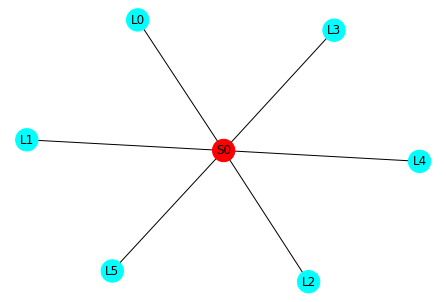

In [7]:
nviz.plot_soma_limb_concept_network(curr_neuron_obj)

In [8]:
nviz.visualize_neuron(curr_neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


# 0) Check that only one soma

In [9]:
soma_names = curr_neuron_obj.get_soma_node_names()
if len(soma_names)>1:
    raise Exception(f"More than 1 soma: {soma_names}")

soma_name = soma_names[0]

In [106]:
verbose = True
ais_threshold = 20000
axon_angle_threshold = 140

# 1) Classify All Axon Segments

In [10]:
axon_like_limb_branch_dict = ns.axon_width_like_segments(curr_neuron_obj,
                                                        include_ais=True)



# nviz.visualize_neuron(curr_neuron_obj,
#                       visualize_type=["mesh"],
#                      limb_branch_dict=axon_like_limb_branch_dict,
#                      mesh_color="red",
#                       mesh_color_alpha=1,
#                      mesh_whole_neuron=True)

current_functions_list = ["axon_segment"]
final_axon_like_classification = ns.query_neuron(curr_neuron_obj,
                                        
                                   query="axon_segment==True",
                                   function_kwargs=dict(limb_branch_dict =axon_like_limb_branch_dict,
                                                        downstream_face_threshold=3000,
                                                        width_match_threshold=50,
                                                       print_flag=False),
                                   functions_list=current_functions_list)

nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh"],
                     limb_branch_dict=final_axon_like_classification,
                     mesh_color="red",
                      mesh_color_alpha=1,
                     mesh_whole_neuron=True)

current_query = (n_spines < 4 and (median_mesh_center < 600) and skeleton_distance_branch <= 15000) or (skeleton_distance_branch > 15000 and (median_mesh_center < 600) and spines_per_skeletal_length < 0.00023)
functions_list = [<function width at 0x7f00f4068d08>, <function median_mesh_center at 0x7f00f40d1048>, <function n_spines at 0x7f00f4068e18>, <function n_faces_branch at 0x7f00f4068b70>, <function skeleton_distance_branch at 0x7f00f4068d90>, <function spines_per_skeletal_length at 0x7f00f40d12f0>, <function no_spine_median_mesh_center at 0x7f00f40d1158>]
functions_list = [<function axon_segment at 0x7f00f40d19d8>]

 Working on visualization type: mesh


In [11]:
# want to label all branches as "axon_like"
current_label = "axon-like"

nru.add_branch_label(curr_neuron_obj,
                    limb_branch_dict=final_axon_like_classification,
                    labels=current_label)


In [12]:
current_functions_list = ["matching_label"]

recovered_axon_branches = ns.query_neuron(curr_neuron_obj,
                query="matching_label==True",
                function_kwargs=dict(labels =["axon-like"]),
                functions_list=current_functions_list
               )

recovered_axon_branches

functions_list = [<function matching_label at 0x7f00f40d1378>]


{'L0': array([ 1,  3,  5,  7,  8, 16, 18, 20, 21, 38, 45]),
 'L1': array([ 3,  4,  9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22]),
 'L2': array([ 4,  6,  8,  9, 11, 12, 13, 14, 15, 16, 23]),
 'L4': array([0]),
 'L5': array([3])}

# 2) Filter Limbs By Starting Angle

In [13]:
axon_soma_angle_threshold = 70

soma_center = curr_neuron_obj["S0"].mesh_center

possible_axon_limbs_dict = ns.query_neuron(curr_neuron_obj,
                query=f"soma_starting_angle>{axon_soma_angle_threshold}",
               functions_list=[ns.soma_starting_angle],
               function_kwargs=dict(soma_center=soma_center,
                                   verbose=True))

possible_axon_limbs = list(possible_axon_limbs_dict.keys())
possible_axon_limbs = [nru.get_limb_int_name(k) for k in possible_axon_limbs]
possible_axon_limbs

functions_list = [<function soma_starting_angle at 0x7f00f40d1d08>]
Limb L0 soma angle: 2.56 
Limb L1 soma angle: 106.07 
Limb L2 soma angle: 98.8 
Limb L3 soma angle: 122.76 
Limb L4 soma angle: 134.4 
Limb L5 soma angle: 106.31 


[1, 2, 3, 4, 5]

# 3) Get all of the Viable Candidates

In [14]:
import classification_utils as clu

In [15]:
axon_subgraph_candidates = clu.axon_candidates(curr_neuron_obj,
                   possible_axon_limbs=possible_axon_limbs,
                        ais_threshold=ais_threshold,
                   plot_candidates_after_adding_back=True,
                   verbose=True)

functions_list = [<function skeletal_distance_from_soma at 0x7f00f40d1840>]
functions_list = [<function skeletal_distance_from_soma at 0x7f00f40d1840>]

Working on Limb L1
nodes_to_eliminate = []

Working on Limb L2
nodes_to_eliminate = [20 22]

Working on Limb L3
nodes_to_eliminate = [3]

Working on Limb L4
nodes_to_eliminate = [0]
The filtered network is empty so just leaving the candidates as empty lists

Working on Limb L5
nodes_to_eliminate = [0]

----Working on Limb L1-----
No nodes were eliminated so don't need to add back any candidates

----Working on Limb L2-----
No endpoints were eliminated so don't need to add back any candidates

----Working on Limb L3-----
No endpoints were eliminated so don't need to add back any candidates

----Working on Limb L4-----
network was only of size 1 and that node was eliminated so returning that as the only candidate

----Working on Limb L5-----
No endpoints were eliminated so don't need to add back any candidates

 Working on visualization 

Final Candidates

Limb 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Limb 2
[2]
[ 0  3  6  7 10]
[ 1  4  5  8  9 11 12 13 14 15 16 17 18 19 21 23 24]

Limb 3
[0 1 2]
[4 5 6]

Limb 4
[0]

Limb 5
[1]
[2 3 4 5]


# Doing the Filtering of the Candidates

In [ ]:
"""
Pseudocode: 

For each candidate: 

0) If all Axon? (Have a more relaxed threshold for the skeleton angle)
1) Find the starting direction, and if not downwards --> then not axon
2) ------------- Check if too thin at the start --> Not Axon (NOT GOING TO DO THIS) -------------
3) If first branch is axon --> classify as axon
4) Trace back to starting node and add all branches that are axon like

"""

In [17]:
import networkx_utils as xu

In [18]:
dir(xu)

['GraphOrderedEdges',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'add_new_coordinate_node',
 'combine_graphs',
 'compare_endpoints',
 'compare_networks',
 'connected_components_from_nodes_edges',
 'copy',
 'deepcopy',
 'downstream_edges',
 'downstream_edges_neighbors',
 'downstream_nodes',
 'edge_to_index',
 'endpoint_connectivity',
 'find_all_cycles',
 'find_nodes_within_certain_distance_of_target_node',
 'find_reciprocal_connections',
 'find_skeletal_distance_along_graph_node_path',
 'get_all_attributes_for_edges',
 'get_all_attributes_for_nodes',
 'get_all_nodes_with_certain_attribute_key',
 'get_coordinate_by_graph_node',
 'get_coordinate_degree',
 'get_edge_attributes',
 'get_edges_with_attributes_dict',
 'get_graph_node_by_coordinate',
 'get_graph_node_by_coordinate_old',
 'get_neighbors',
 'get_node_attributes',
 'get_node_degree',
 'get_node_list',
 'get_nodes_greater_or_equal_degree_k',
 'get_nodes_less_or

In [27]:
curr_limb_idx = 2
curr_limb = curr_neuron_obj[curr_limb_idx]
curr_candidate_idx = 0
curr_candidate_subgraph = np.array(axon_subgraph_candidates[curr_limb_idx][curr_candidate_idx])
curr_candidate_subgraph

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [21]:
nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict={f"L{curr_limb}":curr_candidate_subgraph})


 Working on visualization type: mesh

 Working on visualization type: skeleton


# Finding the shortest path back to starting soma that will be used in some of the later algorithms

In [116]:
axon_subgraph_candidates_passing_angle_filter = dict()

In [34]:
curr_limb.set_concept_network_directional(starting_soma = 0)
curr_limb.current_starting_node,curr_limb.current_starting_coordinate

0

In [32]:
import networkx as nx
undirectional_limb_graph = nx.Graph(curr_limb.concept_network_directional)

In [33]:
undirectional_limb_graph

In [35]:
import networkx_utils as xu

current_shortest_path,st_node,end_node = xu.shortest_path_between_two_sets_of_nodes(
    undirectional_limb_graph,[0],
    curr_candidate_subgraph)


([0], 0, 0)

# Part A: Finding the Starting Skeleton Direction

In [ ]:
def candidate_starting_skeletal_angle(limb_obj,candidate_nodes,
                                      offset = 20000,
                                    axon_sk_direction_comparison_distance = 5000,
                                    buffer_for_skeleton = 5000,
                                      top_volume_vector = np.array([0,-1,0])
                                     )

In [ ]:
"""
Purpose: To get the skeleton that represents the starting skeleton
--> and then find the projection angle to filter it away or not

Pseudocode: 
1) convert the graph into a skeleton (this is when self touches could be a problem)
2) Find all skeleton points that are within a certain distance of the starting coordinate
3) Find all edn-degree nodes (except for the start)
4) Find path back to start for all end-nodes
5) Find paths that are long enough for the offset plus test --> if none then don't filter
anyway

For each valid path (make them ordered paths):
6) Get the offset + test subskeletons for all valid paths
7) Get the angle of the sksletons vectors
8) Filter the candidate away if ALL (ANY) don't make the threshold angle requirement
"""

array([[779602., 969709., 846839.],
       [780569., 967560., 847203.]])

In [91]:
offset = ais_threshold
axon_sk_direction_comparison_distance = 5000
buffer_for_skeleton = 5000
sk_size_to_compare = comparison_distance + offset
total_distance = offset + comparison_distance + buffer_for_skeleton

In [92]:
subgraph_branches = np.unique(np.hstack([curr_candidate_subgraph,current_shortest_path]))
subgraph_branches

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [93]:
#1) convert the graph into a skeleton (this is when self touches could be a problem)
candidate_sk= sk.stack_skeletons([curr_limb[k].skeleton for k in subgraph_branches])
candidate_sk_graph = sk.convert_skeleton_to_graph(candidate_sk)


In [94]:
#2) Find all skeleton points that are within a certain distance of the starting coordinate
starting_sk_coord = curr_limb.current_starting_coordinate
starting_sk_node = xu.get_graph_node_by_coordinate(candidate_sk_graph,starting_sk_coord)
skeletons_nodes_for_comparison = xu.find_nodes_within_certain_distance_of_target_node(
    candidate_sk_graph,
    starting_sk_node,total_distance)
np.array(list(skeletons_nodes_for_comparison))
comparison_subgraph = candidate_sk_graph.subgraph(skeletons_nodes_for_comparison)
comparison_subgraph

In [95]:
#3) Find all edn-degree nodes (except for the start)
all_endnodes = xu.get_nodes_of_degree_k(comparison_subgraph,1)
starting_coordinate_endnode = xu.get_graph_node_by_coordinate(
    comparison_subgraph,
    starting_sk_coord)
endnodes_to_test = np.setdiff1d(all_endnodes,[starting_coordinate_endnode])

if verbose:
    print(f"endnodes_to_test = {endnodes_to_test}")
    
# nviz.plot_objects(curr_limb.mesh,
#             skeletons=[sk.convert_graph_to_skeleton(comparison_subgraph)],
#                  )

endnodes_to_test = [204 221]


In [96]:
#4) Find path back to start for all end-nodes
import networkx as nx
paths_to_test = [nx.shortest_path(comparison_subgraph,
                                  starting_coordinate_endnode,
                                  k
                                 ) for k in endnodes_to_test]
sk_paths_to_test = [sk.convert_graph_to_skeleton(comparison_subgraph.subgraph(k))
                       for k in paths_to_test]
sk_paths_to_test_ordered = [sk.order_skeleton(k,
                                              start_endpoint_coordinate = starting_sk_coord)
                           for k in sk_paths_to_test]

if len(sk_paths_to_test_ordered) <= 0: 
    raise Exception("Found no skeleton paths")
# for k in sk_paths_to_test_ordered:
#     nviz.plot_objects(curr_limb.mesh,
#                      skeletons=[k])

In [97]:
#5) Find paths that are long enough for the offset plus test --> if none then don't filter any

sk_distances = np.array([sk.calculate_skeleton_distance(k) for k in sk_paths_to_test_ordered])
filtered_indexes = np.where(sk_distances>=sk_size_to_compare)[0]


if len(filtered_indexes)> 0:
    filtered_skeletons = [sk_paths_to_test_ordered[k] for k in filtered_indexes]
else:
    filtered_skeletons = sk_paths_to_test_ordered

if verbose:
    print(f"Skeleton paths distances = {sk_distances}")
    print(f"Filtered indexes = {filtered_indexes}")
    print(f"len(filtered_skeletons) = {len(filtered_skeletons)}")

Skeleton paths distances = [29870.36627367 29835.7633328 ]
Filtered indexes = [0 1]
len(filtered_skeletons) = 2


In [98]:
#6) Get the offset + test subskeletons for all valid paths
filtered_skeletons_restricted = [sk.restrict_skeleton_from_start_plus_offset(k,
                                    offset=offset,
                                    comparison_distance=axon_sk_direction_comparison_distance)
         for k in filtered_skeletons]

for k in filtered_skeletons_restricted:
    nviz.plot_objects(curr_limb.mesh,
                     skeletons=[k])

In [115]:
#7) Get the angle of the sletons vectors
top_volume_vector = np.array([0,-1,0])

#angle between going down and skeleton vector
sk_vectors = [sk.skeleton_endpoint_vector(k) for k in filtered_skeletons_restricted]
sk_angles = np.array([nu.angle_between_vectors(top_volume_vector,k) for k in sk_vectors])

sk_passing_threshold = np.where(sk_angles>axon_angle_threshold)[0]

if verbose:
    print(f"Number of skeleton paths passing the axon skeleton threhold = {len(sk_passing_threshold)}")

if len(sk_passing_threshold) > 0:
    if curr_limb_idx not in limbs_passing_angle_filter:
        axon_subgraph_candidates_passing_angle_filter[curr_limb_idx]
    if curr_candidate_idx not in axon_subgraph_candidates_passing_angle_filter[curr_limb_idx]:
        axon_subgraph_candidates_passing_angle_filter[curr_limb_idx].append(curr_candidate_idx)
        
limbs_passing_angle_filter

Number of skeleton paths passing the axon skeleton threhold = 0


[]